# # **ANALYSING THE COVID-19 RISK FACTORS RELATED TO PREGNANT WOMEN AND NEONATES**

**BIOBERT QnA**

Importing the libraries

In [ ]:
import pandas as pd
import numpy as np 

Filtering the covid-19 articles published after 2020

In [ ]:
import re
import os
import json
# keep only documents with covid -cov-2 and cov2
def search_focus(df):
    dfa = df[df['abstract'].str.contains('covid')]
    dfb = df[df['abstract'].str.contains('-cov-2')]
    dfc = df[df['abstract'].str.contains('cov2')]
    dfd = df[df['abstract'].str.contains('ncov')]
    frames=[dfa,dfb,dfc,dfd]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df


df=pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv', usecols=['title','journal','abstract','authors','doi','publish_time','sha','pdf_json_files'])
print ('All CORD19 documents ',df.shape)
#fill na fields
df=df.fillna('no data provided')
#drop duplicate titles
df = df.drop_duplicates(subset='title', keep="first")
#keep only 2020 dated papers
df=df[df['publish_time'].str.contains('2020')]
# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()+df["title"].str.lower()
#show 5 lines of the new dataframe
df=search_focus(df)
print ("COVID-19 focused docuemnts ",df.shape)



def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body
for index, row in df.iterrows():
    if ';' not in row['sha'] and os.path.exists('/kaggle/input/CORD-19-research-challenge/'+row['pdf_json_files']+'/'+row['pdf_json_files']+'/pdf_json/'+row['sha']+'.json')==True:
        with open('/kaggle/input/CORD-19-research-challenge/'+row['pdf_json_files']+'/'+row['pdf_json_files']+'/pdf_json/'+row['sha']+'.json') as json_file:
            data = json.load(json_file)
            body=format_body(data['body_text'])
            keyword_list=['TB','incidence','age']
            #print (body)
            body=body.replace("\n", " ")

            df.loc[index, 'abstract'] = body.lower()

df=df.drop(['pdf_json_files'], axis=1)
df=df.drop(['sha'], axis=1)
# df.head()

In [ ]:
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)

In [ ]:
valid_ids = set(df[df["has_full_text"]==True]["sha"].unique().tolist())

stemmer = PorterStemmer()

tags = [set({"neo-natal", "natal", "pregnancy", "pregnant"," unborn"}),
         set({"covid-19", "covid19", "sars-cov-2", "2019-ncov","ncov","cov2"})]

reverse_map = {}
# convert our target terms into their stemmed versions for compatibility in the matching stage
for i in range(0, len(targs)):
    newterms = set()
    for ele in targs[i]:
        st = stemmer.stem(ele)
        newterms.add(st)
        reverse_map[st] = ele
    targs[i] = newterms

In [ ]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers

In [ ]:
# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English', 'French','Spanish','Chinese'}


Preprocessing

In [ ]:
import nltk
nltk.download("punkt")

from nltk import word_tokenize,sent_tokenize
from nltk.stem  import PorterStemmer


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')
stops = stopwords.words("english")

for i in tokenized: 
      

    wordsList = nltk.word_tokenize(i) 
  
    wordsList = [w for w in wordsList if not w in stop_words]  
  
    # tagger or POS-tagger.  
    tagged = nltk.pos_tag(wordsList) 
  
    print(tagged) 


def removepunc(my_str):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

def hasNumbers(inputString):
    return (bool(re.search(r'\d', inputString)))
snowstem = SnowballStemmer("english")
portstem = PorterStemmer()




usequeries = sent_tokenize("""
Neonates and pregnant women.difference in symptoms of coronavirus disease for pregnant women.
Treatment Options for Pregnant Women Infected with covid-19.difference in symptoms of coronavirus disease for neonates.pregnant women protect themselves against COVID-19.
pregnant women with suspected or confirmed COVID-19 need to give birth by caesarean section.
Can COVID-19 be passed from a woman to her unborn or newborn baby.
What are considerations for neonates at risk for COVID-19?.Will COVID-19 be transmitted vertically to the fetus from the pregnant mother.
will pregnant or recently pregnant women with COVID-19 give birth prematurely.
What are the risks for pregnant women with COVID-19 alongside other co-morbidities.
Will I be able to breastfeed my baby if I have suspected or confirmed coronavirus.
""")
queryarticle = [" ".join([snowstem.stem(removepunc(i.lower())) for i in word_tokenize(x) if i not in stops ]) for x in usequeries]

In [ ]:
df["usetext"] = df.abstract.apply(lambda x: " ".join([snowstem.stem(i) for i in word_tokenize(removepunc(x.lower())) if not hasNumbers(i) if i not in stops]))

Topic modeling using lda and embedding using Bert

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
encArticles = vectorizer.fit_transform(df.usetext)
encQueries = vectorizer.transform(queryarticle)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix  = cosine_similarity(encQueries,encArticles)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
import gensim
import numpy as np
from datetime import datetime




# define model object
class Topic_Model:
    
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")


         if method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
              
                self.AE.fit(vec_ldabert)
           
            vec = self.AE.encoder.predict(vec_ldabert)
            Autoenoder(vec_ldabert)
            
            
            return vec
        
         def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

    def fit(self, sentences, token_lists, method=None, m_clustering=None):

        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

     

    def predict(self, sentences, token_lists, out_of_sample=None):
      
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method:
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method:
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

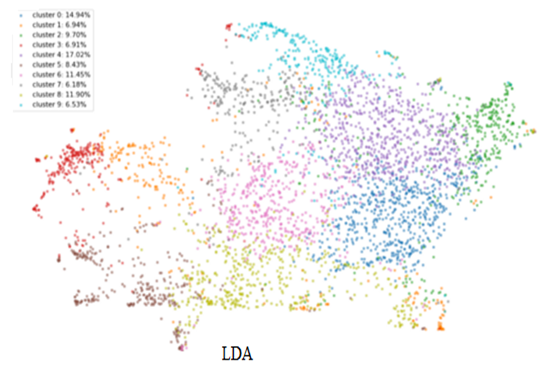

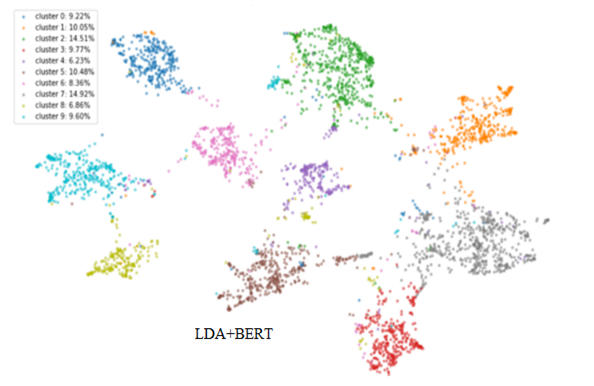

AUTOENCODER-Since the concatenated vector is in a high-dimensional space, where information is sparse and correlated, we should autoencoders.

In [ ]:
### Autoencoder
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:


    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
       
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [ ]:
import torch
from transformers import  AutoTokenizer,AutoModelForQuestionAnswering

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

In [ ]:
def ask(question,context):
  input_ids = tokenizer.encode(question, context)
  sep_index = input_ids.index(tokenizer.sep_token_id)

  num_seg_a = sep_index + 1

  num_seg_b = len(input_ids) - num_seg_a
  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  assert len(segment_ids) == len(input_ids)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)


  start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
  answer_end = 0
  answer_start = torch.argmax(start_scores)
  answer_ends = torch.argsort(end_scores).numpy()[::-1]
  for i in answer_ends[0]:
    if answer_start<= i:
      answer_end= i

  answer = ' '.join(tokens[answer_start:answer_end+1])
  answer = answer.replace(" ##","").replace("[CLS] ","")

  pack = [answer,answer_start,answer_end,torch.max(start_scores),end_scores[0][answer_end],(torch.max(start_scores)+end_scores[0][answer_end]),context]
  return pack

In [ ]:
from IPython.display import display, HTML

In [ ]:
"""
this function is used to visualize the answers with their contexts 
"""

def highlightTextInContext(answer, context):
    if "?"  in answer:
        answer =" ".join(answer[answer.index("?")+1:].split(" "))
    
    antokens = word_tokenize(answer)
    cotokens = word_tokenize(context)
    startword= ""
    startindex= ""
    for i,w in enumerate(antokens):
        for c in cotokens:
            if c==w:
                startword = c 
                selectedText = context[context.index(w):context.index(antokens[-1])+len(antokens[-1])]
                highlighted = f'<span style="color: grey; font-weight: bold">{selectedText}</span>'
                return context.replace(selectedText,highlighted)
                # return is an easy way to break two nested loops
def showTopAnswers(answers):
        for i in np.argsort(answers[:,5])[-8:][::-1]:
            display(HTML("<p>"+highlightTextInContext(answers[i,0],answers[i,6])+"</p>"))

In [ ]:
def getanswers(question):
  recommendations = []
  for i in range(len(usequeries)):
    indecies = np.argsort(similarity_matrix[i])[-7:][::-1] ## I choose to show N recommended queries from every query
    for t in indecies:
        recommendations.append(word_tokenize(df.abstract[t]))
  
  processedQuestion =   " ".join([snowstem.stem(i) for i in word_tokenize(removepunc(question)) if i not in stops])
  vector = vectorizer.transform([processedQuestion])
  questionSimilarityMatrix = cosine_similarity(vector,encArticles)
  indecies = np.argsort(questionSimilarityMatrix[0])[-7:][::-1] 
  for t in indecies:
    recommendations.append(word_tokenize(df.abstract[t]))
          
  questions= []
  contexts= []
  for bigcontext in recommendations:
    for i in range(int(len(bigcontext)/60)):
      contexts.append(" ".join(bigcontext[i*60:60*(i+1)]))
      questions.append(question)

  answers = []
  for  question, context in zip(questions,contexts):
    result = ask(question,context)
    if len(result[0]) < 7 and "[CLS]" in result[0] :
      continue
    answers.append(result)
  answers = np.array(answers)

  return answers

In [ ]:
answers = getanswers("Is there any difference in symptoms of coronavirus disease for pregnant women ?")
showTopAnswers(answers)

In [ ]:
answers = getanswers("What are the Treatment Options for Pregnant Women Infected with COVID-19 ?")
showTopAnswers(answers)

In [ ]:
answers = getanswers("Is there any difference in symptoms of coronavirus disease for neonates?")
showTopAnswers(answers)

In [ ]:
answers = getanswers("Who is most at risk for COVID-19 pregnant women or non-pregnant women ?")
showTopAnswers(answers)

In [ ]:
answers = getanswers("How can pregnant women protect themselves against COVID-19 ?")
showTopAnswers(answers)

In [ ]:

answers = getanswers("Will I be able to breastfeed my baby if I have suspected or confirmed coronavirus?")
showTopAnswers(answers)

In [ ]:

answers = getanswers("Do pregnant women with suspected or confirmed COVID-19 need to give birth by caesarean section?")
showTopAnswers(answers)

In [ ]:


answers = getanswers("Can COVID-19 be passed from a woman to her unborn or newborn baby ?")
showTopAnswers(answers)

In [ ]:

answers = getanswers("What are considerations for neonates at risk for COVID-19 ?")
showTopAnswers(answers)

In [ ]:

answers = getanswers("Will COVID-19 be transmitted vertically to the fetus from the pregnant mother ?")
showTopAnswers(answers)

In [ ]:

answers = getanswers("will pregnant or recently pregnant women with COVID-19 give birth prematurely?")
showTopAnswers(answers)